<a href="https://colab.research.google.com/github/marianaernu/ml-product-reviews-project/blob/main/notebook/product_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictia categoriei produsului

## 1. Incarcarea dataset-ului din Github

In [2]:
import pandas as pd


url = "https://raw.githubusercontent.com/marianaernu/ml-product-reviews-project/main/data/products.csv"

df = pd.read_csv(url)
print("Number of rows:", len(df))
print("First 5 rows:")
print(df.head())

Number of rows: 35311
First 5 rows:
   product ID                                      Product Title  Merchant ID  \
0           1                    apple iphone 8 plus 64gb silver            1   
1           2                apple iphone 8 plus 64 gb spacegrau            2   
2           3  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...            3   
3           4                apple iphone 8 plus 64gb space grey            4   
4           5  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...            5   

   Category Label _Product Code  Number_of_Views  Merchant Rating  \
0   Mobile Phones    QA-2276-XC            860.0              2.5   
1   Mobile Phones    KA-2501-QO           3772.0              4.8   
2   Mobile Phones    FP-8086-IE           3092.0              3.9   
3   Mobile Phones    YI-0086-US            466.0              3.4   
4   Mobile Phones    NZ-3586-WP           4426.0              1.6   

   Listing Date    
0       5/10/2024  
1      12/31/2024  
2 

## 2. Curățarea coloanelor (eliminarea spațiilor)

In [3]:
# Eliminăm spațiile din capul coloanelor
df.columns = [c.strip() for c in df.columns]

print("Coloanele dataset-ului:", df.columns)

Coloanele dataset-ului: Index(['product ID', 'Product Title', 'Merchant ID', 'Category Label',
       '_Product Code', 'Number_of_Views', 'Merchant Rating', 'Listing Date'],
      dtype='object')


## 3. Curatarea titlurilor produselor

In [4]:
import re

def clean_title(s):
    if pd.isna(s):
        return ""
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9\u00C0-\u017F\s\-\_\.]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Aplicăm curățarea
df['clean_title'] = df['Product Title'].apply(clean_title)

df[['Product Title', 'clean_title']].head()

,Product Title,clean_title
0,apple iphone 8 plus 64gb silver,apple iphone 8 plus 64gb silver
1,apple iphone 8 plus 64 gb spacegrau,apple iphone 8 plus 64 gb spacegrau
2,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,apple mq8n2b a iphone 8 plus 64gb 5.5 12mp sim...
3,apple iphone 8 plus 64gb space grey,apple iphone 8 plus 64gb space grey
4,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...


## 3.1 Curatarea randurilor cu valori lipsa:

In [7]:
# Eliminăm rândurile care au NaN în Category Label sau clean_title
df = df.dropna(subset=['Category Label', 'clean_title'])

print("Număr rânduri după curățare:", len(df))

Număr rânduri după curățare: 35267


## 4. Analiza datelor: top categorii

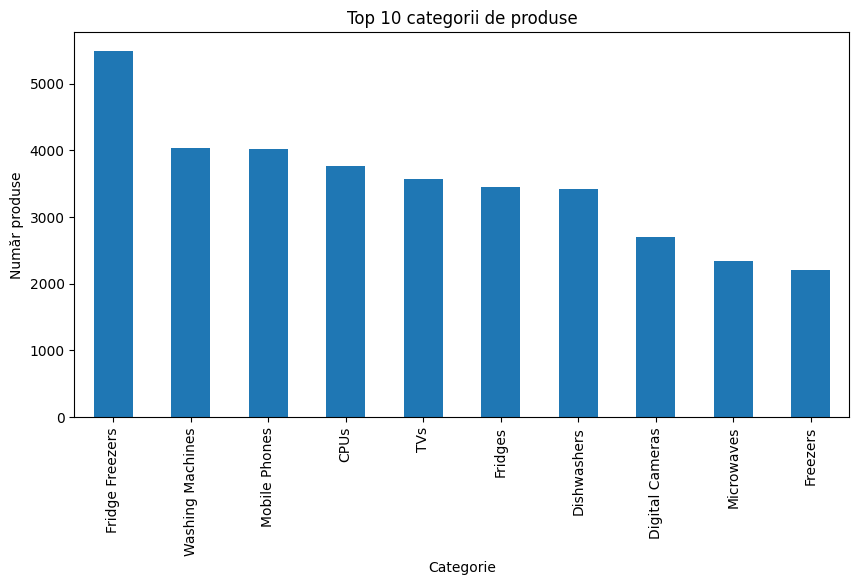

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df['Category Label'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 categorii de produse")
plt.xlabel("Categorie")
plt.ylabel("Număr produse")
plt.show()

## 5. Împărțirea dataset-ului în train și test

In [8]:
from sklearn.model_selection import train_test_split

X = df['clean_title']
y = df['Category Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Dimensiunea setului de antrenament:", len(X_train))
print("Dimensiunea setului de test:", len(X_test))

Dimensiunea setului de antrenament: 28213
Dimensiunea setului de test: 7054


## 6. Vectorizare TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Dimensiunea matricei TF-IDF:", X_train_vec.shape)

Dimensiunea matricei TF-IDF: (28213, 30000)


## 7. Antrenarea modelului Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000, solver="saga", n_jobs=-1)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.946

Classification Report:
                   precision    recall  f1-score   support

             CPU       0.00      0.00      0.00        17
            CPUs       0.98      0.99      0.98       754
 Digital Cameras       0.99      0.99      0.99       539
     Dishwashers       0.95      0.94      0.94       684
        Freezers       0.98      0.88      0.93       442
 Fridge Freezers       0.92      0.94      0.93      1099
         Fridges       0.86      0.90      0.88       691
      Microwaves       1.00      0.96      0.98       468
    Mobile Phone       0.00      0.00      0.00        11
   Mobile Phones       0.91      1.00      0.95       804
             TVs       0.99      0.97      0.98       713
Washing Machines       0.95      0.95      0.95       807
          fridge       0.00      0.00      0.00        25

        accuracy                           0.95      7054
       macro avg       0.73      0.73      0.73      7054
    weighted avg       0.94  

## 8. Salvarea modelului pentru predicții viitoare

In [11]:
import pickle
import os

os.makedirs("models", exist_ok=True)

with open("models/product_category_model.pkl", "wb") as f:
    pickle.dump((vectorizer, model), f)

print(" Model salvat în models/product_category_model.pkl")

 Model salvat în models/product_category_model.pkl


## 9. Testarea rapida a predictiilor

In [12]:
def predict_category(title):
    clean = clean_title(title)
    vec = vectorizer.transform([clean])
    return model.predict(vec)[0]

examples = [
    "iphone 7 32gb gold",
    "olympus e m10 mark iii geh use silber",
    "kenwood k20mss15 solo",
    "bosch serie 4 kgv39vl31g",
    "smeg sbs8004po",
]

for e in examples:
    print(f"{e} → {predict_category(e)}")

iphone 7 32gb gold → Mobile Phones
olympus e m10 mark iii geh use silber → Digital Cameras
kenwood k20mss15 solo → Microwaves
bosch serie 4 kgv39vl31g → Dishwashers
smeg sbs8004po → Fridges
